# Demo: Data Validation and Quality Assessment with vivainsights

This notebook demonstrates how to use the data validation functions from the **vivainsights** Python package to assess data quality, identify anomalies, and prepare your Viva Insights data for analysis.

Data validation is a critical first step in any analytics workflow. Before drawing insights from your collaboration data, it's essential to:

- **Identify data quality issues** like outliers, missing values, and anomalies
- **Detect holiday weeks and inactive periods** that might skew analysis
- **Understand your organizational structure** and HR attributes
- **Assess data completeness** and coverage across time periods
- **Flag potential data issues** before conducting analysis

In this walkthrough, you will:
1. Load and explore the demo data structure
2. Identify and extract HR attributes with `extract_hr()`
3. Detect holiday weeks and anomalous periods with `identify_holidayweeks()`
4. Find outliers in collaboration metrics with `identify_outlier()`
5. Identify inactive weeks for individuals with `identify_inactiveweeks()`
6. Analyze employee churn and tenure patterns
7. Validate date ranges and data completeness
8. Best practices for data quality assessment

In [1]:
# Import necessary libraries
import vivainsights as vi
import pandas as pd
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## Step 1: Load and Explore the Demo Data

First, let's load the sample Person Query dataset and get an overview of its structure. Understanding your data structure is the foundation of effective validation.

In [2]:
# Load the demo data
pq_data = vi.load_pq_data()

# Display basic information about the dataset
print(f"📈 Dataset shape: {pq_data.shape[0]:,} rows × {pq_data.shape[1]} columns")
print(f"📅 Date range: {pq_data['MetricDate'].min()} to {pq_data['MetricDate'].max()}")
print(f"👥 Unique employees: {pq_data['PersonId'].nunique():,}")
print(f"⏰ Time periods: {pq_data['MetricDate'].nunique()} unique weeks")

# Display the first few rows
print("\n📋 Sample of the data:")
pq_data.head()

📈 Dataset shape: 10,500 rows × 73 columns
📅 Date range: 2024-03-31 to 2024-11-24
👥 Unique employees: 300
⏰ Time periods: 35 unique weeks

📋 Sample of the data:


,PersonId,MetricDate,Collaboration_hours,Copilot_actions_taken_in_Teams,Meeting_and_call_hours,Internal_network_size,Email_hours,Channel_message_posts,Conflicting_meeting_hours,Large_and_long_meeting_hours,...,Summarise_chat_actions_taken_using_Copilot_in_Teams,Summarise_email_thread_actions_taken_using_Copilot_in_Outlook,Summarise_meeting_actions_taken_using_Copilot_in_Teams,Summarise_presentation_actions_taken_using_Copilot_in_PowerPoint,Summarise_Word_document_actions_taken_using_Copilot_in_Word,FunctionType,SupervisorIndicator,Level,Organization,LevelDesignation
0,bf361ad4-fc29-432f-95f3-837e689f4ac4,2024-03-31,17.452987,4,11.767599,92,7.523189,0.753451,2.079210,0.635489,...,2,0,0,0,0,Specialist,Manager,Level3,IT,Senior IC
1,0500f22c-2910-4154-b6e2-66864898d848,2024-03-31,32.860820,6,26.743370,193,11.578396,0.000000,8.106997,1.402567,...,2,0,4,1,0,Specialist,Manager,Level2,Legal,Senior Manager
2,bb495ec9-8577-468a-8b48-e32677442f51,2024-03-31,21.502359,8,13.982031,113,9.073214,0.894786,3.001401,0.000192,...,1,1,0,0,0,Manager,Manager,Level4,Legal,Junior IC
3,f6d58aaf-a2b2-42ab-868f-d7ac2e99788d,2024-03-31,25.416502,4,16.895513,131,10.281204,0.528731,1.846423,1.441596,...,0,0,0,0,0,Manager,Manager,Level1,HR,Executive
4,c81cb49a-aa27-4cfc-8211-4087b733a3c6,2024-03-31,11.433377,4,6.957468,75,5.510535,2.288934,0.474048,0.269996,...,0,0,1,0,0,Technician,Manager,Level1,Finance,Executive


In [3]:
# Check data types and missing values
print("🔍 Data Quality Overview:")
print(f"Missing values per column:")
missing_data = pq_data.isnull().sum()
missing_data[missing_data > 0].sort_values(ascending=False)

🔍 Data Quality Overview:
Missing values per column:


Series([], dtype: int64)

## Step 2: Extract and Validate HR Attributes

The `extract_hr()` function helps you identify organizational attributes (HR variables) in your dataset. These are typically categorical variables that represent different organizational dimensions like department, level, location, etc.

Understanding your HR attributes is crucial for:
- **Group-based analysis** and comparisons
- **Privacy protection** (ensuring minimum group sizes)
- **Data validation** (checking for expected organizational structure)

In [4]:
# Extract HR attributes from the data
print("🏢 Organizational attributes (HR variables) found in the data:")
vi.extract_hr(data=pq_data)

🏢 Organizational attributes (HR variables) found in the data:
MetricDate,
 FunctionType,
 SupervisorIndicator,
 Level,
 Organization,
 LevelDesignation,



In [5]:
# Get the actual HR variables as a list for further analysis
hr_vars = vi.extract_hr(data=pq_data, return_type="suggestion")
print(f"📝 HR variables list: {hr_vars}")

# Examine the distribution of each HR variable
print("\n📊 Distribution of organizational attributes:")
for var in hr_vars:
    unique_count = pq_data[var].nunique()
    print(f"  {var}: {unique_count} unique values")
    if unique_count <= 10:  # Show values for small categories
        print(f"    Values: {list(pq_data[var].unique())}")
    print()

📝 HR variables list: ['MetricDate', 'FunctionType', 'SupervisorIndicator', 'Level', 'Organization', 'LevelDesignation']

📊 Distribution of organizational attributes:
  MetricDate: 35 unique values

  FunctionType: 5 unique values
    Values: ['Specialist', 'Manager', 'Technician', 'Consultant', 'Advisor']

  SupervisorIndicator: 2 unique values
    Values: ['Manager', 'IC']

  Level: 4 unique values
    Values: ['Level3', 'Level2', 'Level4', 'Level1']

  Organization: 7 unique values
    Values: ['IT', 'Legal', 'HR', 'Finance', 'Research', 'Sales', 'Operations']

  LevelDesignation: 4 unique values
    Values: ['Senior IC', 'Senior Manager', 'Junior IC', 'Executive']



In [6]:
# Validate HR attribute completeness
print("🔍 HR Attribute Completeness Check:")
for var in hr_vars:
    missing_count = pq_data[var].isnull().sum()
    missing_pct = (missing_count / len(pq_data)) * 100
    
    if missing_count > 0:
        print(f"⚠️  {var}: {missing_count:,} missing values ({missing_pct:.1f}%)")
    else:
        print(f"✅ {var}: Complete (no missing values)")

🔍 HR Attribute Completeness Check:
✅ MetricDate: Complete (no missing values)
✅ FunctionType: Complete (no missing values)
✅ SupervisorIndicator: Complete (no missing values)
✅ Level: Complete (no missing values)
✅ Organization: Complete (no missing values)
✅ LevelDesignation: Complete (no missing values)


## Step 3: Identify Holiday Weeks and Anomalous Periods

The `identify_holidayweeks()` function detects weeks where collaboration activity is significantly below normal levels. These periods often correspond to:

- **Company holidays** (Christmas, New Year, etc.)
- **Vacation periods** (summer holidays, spring break)
- **System outages** or data collection issues
- **Organizational events** (all-hands meetings, training weeks)

Identifying these periods is important because they can skew analysis results if not properly handled.

In [7]:
# Identify holiday weeks using different standard deviation thresholds
print("🎄 Holiday Week Detection:")
print("\n📉 Conservative threshold (1 standard deviation):")
holiday_result_1sd = vi.identify_holidayweeks(pq_data, sd=1, return_type="text")
print(holiday_result_1sd)

print("\n📉 Moderate threshold (0.75 standard deviation):")
holiday_result_075sd = vi.identify_holidayweeks(pq_data, sd=0.75, return_type="text")
print(holiday_result_075sd)

print("\n📉 Sensitive threshold (0.5 standard deviation):")
holiday_result_05sd = vi.identify_holidayweeks(pq_data, sd=0.5, return_type="text")
print(holiday_result_05sd)

🎄 Holiday Week Detection:

📉 Conservative threshold (1 standard deviation):
The weeks where collaboration was 1 standard deviations below the mean (23.1) are: `05/05/2024`, `07/14/2024`, `07/21/2024`, `08/25/2024`, `09/01/2024`, `09/08/2024`, `09/15/2024`

📉 Moderate threshold (0.75 standard deviation):
The weeks where collaboration was 0.75 standard deviations below the mean (23.1) are: `03/31/2024`, `05/05/2024`, `07/14/2024`, `07/21/2024`, `08/25/2024`, `09/01/2024`, `09/08/2024`, `09/15/2024`

📉 Sensitive threshold (0.5 standard deviation):
The weeks where collaboration was 0.5 standard deviations below the mean (23.1) are: `03/31/2024`, `04/28/2024`, `05/05/2024`, `07/07/2024`, `07/14/2024`, `07/21/2024`, `08/25/2024`, `09/01/2024`, `09/08/2024`, `09/15/2024`, `10/06/2024`


📊 Holiday Weeks Visualization:


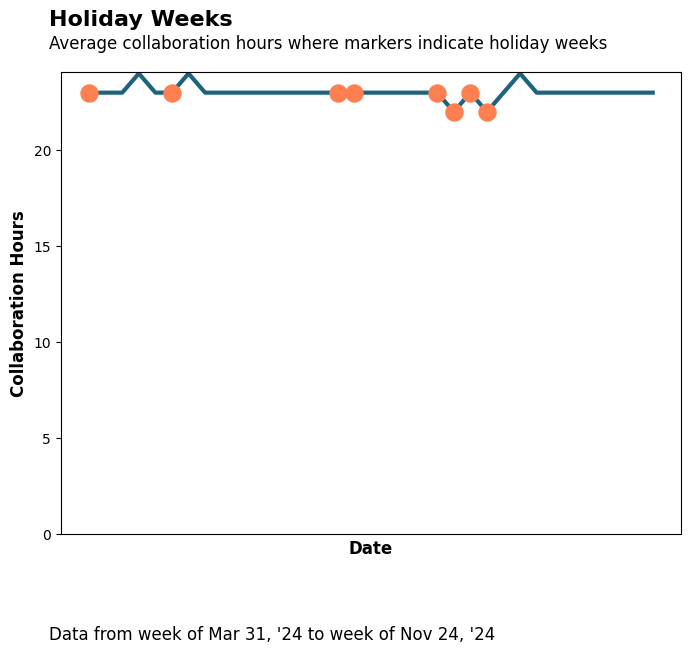

In [8]:
# Visualize holiday weeks detection
print("📊 Holiday Weeks Visualization:")
holiday_plot = vi.identify_holidayweeks(pq_data, sd=0.75, return_type="plot")
holiday_plot.show()

In [9]:
# Get cleaned data with holiday weeks removed
pq_data_cleaned = vi.identify_holidayweeks(pq_data, sd=0.75, return_type="cleaned_data")

print(f"📊 Original data: {pq_data.shape[0]:,} rows")
print(f"📊 Cleaned data: {pq_data_cleaned.shape[0]:,} rows")
print(f"🗑️  Removed: {pq_data.shape[0] - pq_data_cleaned.shape[0]:,} rows ({((pq_data.shape[0] - pq_data_cleaned.shape[0]) / pq_data.shape[0] * 100):.1f}%)")

The weeks 2024-03-31, 2024-05-05, 2024-07-14, 2024-07-21, 2024-08-25, 2024-09-01, 2024-09-08, 2024-09-15 have been flagged as holiday weeks and removed from the data.
This is based on a standard deviation of 0.75 below the mean collaboration hours.
📊 Original data: 10,500 rows
📊 Cleaned data: 8,100 rows
🗑️  Removed: 2,400 rows (22.9%)


In [10]:
# Examine the holiday weeks data in detail
holiday_weeks_data = vi.identify_holidayweeks(pq_data, sd=0.75, return_type="holidayweeks_data")

if not holiday_weeks_data.empty:
    print("🎄 Holiday Weeks Analysis:")
    print(f"Number of affected employees: {holiday_weeks_data['PersonId'].nunique():,}")
    print(f"Holiday weeks identified: {holiday_weeks_data['MetricDate'].unique()}")
    
    # Show collaboration hours during holiday weeks
    avg_collab_holiday = holiday_weeks_data['Collaboration_hours'].mean()
    avg_collab_normal = pq_data_cleaned['Collaboration_hours'].mean()
    
    print(f"\n📊 Collaboration Hours Comparison:")
    print(f"  Holiday weeks: {avg_collab_holiday:.1f} hours/week")
    print(f"  Normal weeks: {avg_collab_normal:.1f} hours/week")
    print(f"  Difference: {avg_collab_normal - avg_collab_holiday:.1f} hours/week ({((avg_collab_normal - avg_collab_holiday) / avg_collab_normal * 100):.1f}% reduction)")
else:
    print("✅ No holiday weeks detected with the current threshold.")

🎄 Holiday Weeks Analysis:
Number of affected employees: 300
Holiday weeks identified: <DatetimeArray>
['2024-03-31 00:00:00', '2024-05-05 00:00:00', '2024-07-14 00:00:00',
 '2024-07-21 00:00:00', '2024-08-25 00:00:00', '2024-09-01 00:00:00',
 '2024-09-08 00:00:00', '2024-09-15 00:00:00']
Length: 8, dtype: datetime64[ns]

📊 Collaboration Hours Comparison:
  Holiday weeks: 22.6 hours/week
  Normal weeks: 23.2 hours/week
  Difference: 0.6 hours/week (2.7% reduction)


## Step 4: Detect Outliers in Collaboration Metrics

The `identify_outlier()` function uses z-scores to identify weeks with abnormal collaboration activity across the entire organization. This helps you spot:

- **System-wide anomalies** affecting multiple employees
- **Data collection issues** on specific dates
- **Organizational events** that impact collaboration patterns
- **Unusual business periods** (busy seasons, quiet periods)

Z-scores indicate how many standard deviations a value is from the mean. Typically:
- **|z| > 2**: Moderate outlier
- **|z| > 3**: Strong outlier

In [11]:
# Identify outliers in collaboration hours by date
outliers_by_date = vi.identify_outlier(
    data=pq_data,
    group_var="MetricDate",
    metric="Collaboration_hours"
)

print("📊 Collaboration Hours Outliers by Date:")
print(f"Date range: {outliers_by_date.index.min()} to {outliers_by_date.index.max()}")
print(f"Number of weeks analyzed: {len(outliers_by_date)}")

# Display the top and bottom outliers
outliers_by_date_sorted = outliers_by_date.sort_values('zscore')

print("\n🔴 Lowest Collaboration Weeks (Potential Holidays/Issues):")
low_outliers = outliers_by_date_sorted.head(3)
for date, row in low_outliers.iterrows():
    print(f"  {date.date()}: {row['Collaboration_hours']:.1f} hours (z-score: {row['zscore']:.2f})")

print("\n🔵 Highest Collaboration Weeks (Potential Busy Periods):")
high_outliers = outliers_by_date_sorted.tail(3)
for date, row in high_outliers.iterrows():
    print(f"  {date.date()}: {row['Collaboration_hours']:.1f} hours (z-score: {row['zscore']:.2f})")

📊 Collaboration Hours Outliers by Date:
Date range: 2024-03-31 00:00:00 to 2024-11-24 00:00:00
Number of weeks analyzed: 35

🔴 Lowest Collaboration Weeks (Potential Holidays/Issues):
  2024-09-15: 22.5 hours (z-score: -1.66)
  2024-09-01: 22.5 hours (z-score: -1.58)
  2024-07-14: 22.5 hours (z-score: -1.49)

🔵 Highest Collaboration Weeks (Potential Busy Periods):
  2024-04-21: 23.5 hours (z-score: 1.32)
  2024-09-29: 23.7 hours (z-score: 1.77)
  2024-05-12: 23.9 hours (z-score: 2.38)


In [12]:
# Identify strong outliers (|z-score| > 2)
strong_outliers = outliers_by_date[abs(outliers_by_date['zscore']) > 2]

if not strong_outliers.empty:
    print(f"⚠️  Found {len(strong_outliers)} weeks with strong outliers (|z-score| > 2):")
    for date, row in strong_outliers.iterrows():
        direction = "↑ High" if row['zscore'] > 0 else "↓ Low"
        print(f"  {date.date()}: {row['Collaboration_hours']:.1f} hours (z-score: {row['zscore']:.2f}) {direction}")
else:
    print("✅ No strong outliers (|z-score| > 2) detected in collaboration hours by date.")

⚠️  Found 1 weeks with strong outliers (|z-score| > 2):
  2024-05-12: 23.9 hours (z-score: 2.38) ↑ High


In [13]:
# Analyze outliers by organizational attribute
print("🏢 Outlier Analysis by Organization:")
outliers_by_org = vi.identify_outlier(
    data=pq_data,
    group_var="Organization",
    metric="Collaboration_hours"
)

outliers_by_org_sorted = outliers_by_org.sort_values('zscore')
print("\nOrganizations with unusual collaboration patterns:")
for org, row in outliers_by_org_sorted.iterrows():
    if abs(row['zscore']) > 1.5:  # Moderate threshold for organizations
        direction = "High" if row['zscore'] > 0 else "Low"
        print(f"  {org}: {row['Collaboration_hours']:.1f} hours (z-score: {row['zscore']:.2f}) - {direction}")

🏢 Outlier Analysis by Organization:

Organizations with unusual collaboration patterns:
  Legal: 22.7 hours (z-score: -1.84) - Low


## Step 5: Identify Inactive Weeks for Individuals

The `identify_inactiveweeks()` function detects weeks where individual employees have unusually low collaboration activity. This can help identify:

- **Employee vacation periods**
- **Sick leave or personal time off**
- **Role transitions or onboarding periods**
- **Data quality issues** for specific employees
- **Potential disengagement patterns**

This analysis is performed at the individual level, considering each person's normal collaboration patterns.

In [14]:
# Identify inactive weeks using different thresholds
print("😴 Individual Inactive Week Detection:")

# Conservative threshold (2 standard deviations)
inactive_result_2sd = vi.identify_inactiveweeks(pq_data, sd=2, return_type="text")
print(f"\n📉 Conservative (2 SD): {inactive_result_2sd}")

# Moderate threshold (1.5 standard deviations)
inactive_result_15sd = vi.identify_inactiveweeks(pq_data, sd=1.5, return_type="text")
print(f"📉 Moderate (1.5 SD): {inactive_result_15sd}")

# Sensitive threshold (1 standard deviation)
inactive_result_1sd = vi.identify_inactiveweeks(pq_data, sd=1, return_type="text")
print(f"📉 Sensitive (1 SD): {inactive_result_1sd}")

😴 Individual Inactive Week Detection:

📉 Conservative (2 SD): There are 226 rows of data with weekly collaboration hours more than 2 standard deviations below the mean 23.1.

📉 Conservative (2 SD): There are 226 rows of data with weekly collaboration hours more than 2 standard deviations below the mean 23.1.
📉 Moderate (1.5 SD): There are 698 rows of data with weekly collaboration hours more than 1.5 standard deviations below the mean 23.1.
📉 Moderate (1.5 SD): There are 698 rows of data with weekly collaboration hours more than 1.5 standard deviations below the mean 23.1.
📉 Sensitive (1 SD): There are 1744 rows of data with weekly collaboration hours more than 1 standard deviations below the mean 23.1.
📉 Sensitive (1 SD): There are 1744 rows of data with weekly collaboration hours more than 1 standard deviations below the mean 23.1.


In [15]:
# Get detailed data on inactive weeks
inactive_data = vi.identify_inactiveweeks(pq_data, sd=1.5, return_type="dirty_data")

if not inactive_data.empty:
    print(f"📊 Inactive Weeks Analysis (1.5 SD threshold):")
    print(f"Total inactive week instances: {len(inactive_data):,}")
    print(f"Employees with inactive weeks: {inactive_data['PersonId'].nunique():,}")
    print(f"Percentage of total employees: {(inactive_data['PersonId'].nunique() / pq_data['PersonId'].nunique() * 100):.1f}%")
    
    # Analyze patterns
    inactive_by_person = inactive_data['PersonId'].value_counts()
    print(f"\n👤 Individual Patterns:")
    print(f"  Employees with 1 inactive week: {sum(inactive_by_person == 1):,}")
    print(f"  Employees with 2-3 inactive weeks: {sum((inactive_by_person >= 2) & (inactive_by_person <= 3)):,}")
    print(f"  Employees with 4+ inactive weeks: {sum(inactive_by_person >= 4):,}")
    
    # Show employees with most inactive weeks
    if len(inactive_by_person) > 0:
        print(f"\n🔍 Top employees with inactive weeks:")
        for person_id, count in inactive_by_person.head(5).items():
            avg_collab = inactive_data[inactive_data['PersonId'] == person_id]['Collaboration_hours'].mean()
            print(f"  {person_id}: {count} inactive weeks (avg: {avg_collab:.1f} hours)")
else:
    print("✅ No inactive weeks detected with the current threshold.")

📊 Inactive Weeks Analysis (1.5 SD threshold):
Total inactive week instances: 698
Employees with inactive weeks: 294
Percentage of total employees: 98.0%

👤 Individual Patterns:
  Employees with 1 inactive week: 58
  Employees with 2-3 inactive weeks: 206
  Employees with 4+ inactive weeks: 30

🔍 Top employees with inactive weeks:
  c8788dd2-db5f-48d0-84e1-e9fef4289535: 5 inactive weeks (avg: 10.4 hours)
  db8cebfd-f69f-41b8-bc6b-9eda03f4913e: 5 inactive weeks (avg: 12.3 hours)
  8d791976-fc9b-4f64-9ad2-5a79754fb5a5: 4 inactive weeks (avg: 13.7 hours)
  c253bb73-33c6-4560-9b98-a0a1e1ff60da: 4 inactive weeks (avg: 12.1 hours)
  a315ad99-0f04-45b6-ad9d-5d45eea1e230: 4 inactive weeks (avg: 10.8 hours)


In [16]:
# Get cleaned data with inactive weeks removed
pq_data_no_inactive = vi.identify_inactiveweeks(pq_data, sd=1.5, return_type="cleaned_data")

print(f"🧹 Data Cleaning Impact:")
print(f"  Original dataset: {pq_data.shape[0]:,} rows")
print(f"  After removing inactive weeks: {pq_data_no_inactive.shape[0]:,} rows")
print(f"  Removed: {pq_data.shape[0] - pq_data_no_inactive.shape[0]:,} rows ({((pq_data.shape[0] - pq_data_no_inactive.shape[0]) / pq_data.shape[0] * 100):.1f}%)")

# Compare collaboration hours before and after cleaning
avg_before = pq_data['Collaboration_hours'].mean()
avg_after = pq_data_no_inactive['Collaboration_hours'].mean()
print(f"\n📊 Collaboration Hours Impact:")
print(f"  Before cleaning: {avg_before:.1f} hours/week")
print(f"  After cleaning: {avg_after:.1f} hours/week")
print(f"  Change: +{avg_after - avg_before:.1f} hours/week ({((avg_after - avg_before) / avg_before * 100):.1f}%)")

🧹 Data Cleaning Impact:
  Original dataset: 10,500 rows
  After removing inactive weeks: 9,802 rows
  Removed: 698 rows (6.6%)

📊 Collaboration Hours Impact:
  Before cleaning: 23.1 hours/week
  After cleaning: 23.9 hours/week
  Change: +0.8 hours/week (3.5%)


## Step 6: Analyze Employee Churn and New Joiners

The `identify_churn()` function helps you understand employee turnover patterns by comparing who was present in the first part of your data period versus the last part. This analysis can reveal:

- **Employee churn rates** over time
- **New joiner patterns** and onboarding periods
- **Data coverage consistency** across time periods
- **Organizational growth or contraction** trends

Understanding churn is important for:
- Ensuring analysis conclusions aren't biased by changing populations
- Identifying data quality issues
- Planning longitudinal studies

In [17]:
# Analyze employee churn (employees who left)
print("🚪 Employee Churn Analysis:")

# Check churn with different time windows
churn_message_4w = vi.identify_churn(pq_data, n1=4, n2=4, return_type="text", flip=False)
print(f"\n📅 4-week comparison: {churn_message_4w}")

churn_message_6w = vi.identify_churn(pq_data, n1=6, n2=6, return_type="text", flip=False)
print(f"📅 6-week comparison: {churn_message_6w}")

churn_message_8w = vi.identify_churn(pq_data, n1=8, n2=8, return_type="text", flip=False)
print(f"📅 8-week comparison: {churn_message_8w}")

🚪 Employee Churn Analysis:

📅 4-week comparison: Churn:
There are 0 employees from 2024-03-31 to 2024-04-21 (4 weeks) who are no longer present in 2024-11-03 to 2024-11-24 (4 weeks).
📅 6-week comparison: Churn:
There are 0 employees from 2024-03-31 to 2024-05-05 (6 weeks) who are no longer present in 2024-10-20 to 2024-11-24 (6 weeks).
📅 8-week comparison: Churn:
There are 0 employees from 2024-03-31 to 2024-05-19 (8 weeks) who are no longer present in 2024-10-06 to 2024-11-24 (8 weeks).


In [18]:
# Get the actual list of churned employees
churned_employees = vi.identify_churn(pq_data, n1=6, n2=6, return_type="data", flip=False)

if len(churned_employees) > 0:
    print(f"🔍 Detailed Churn Analysis (6-week window):")
    print(f"Number of churned employees: {len(churned_employees)}")
    
    # Analyze characteristics of churned employees
    first_6_weeks = sorted(pq_data['MetricDate'].unique())[:6]
    churned_data = pq_data[
        (pq_data['PersonId'].isin(churned_employees)) & 
        (pq_data['MetricDate'].isin(first_6_weeks))
    ]
    
    if not churned_data.empty:
        print(f"\n📊 Churned Employee Characteristics:")
        for hr_var in ['Organization', 'LevelDesignation', 'FunctionType']:
            if hr_var in churned_data.columns:
                churn_dist = churned_data[hr_var].value_counts()
                print(f"  {hr_var}: {dict(churn_dist)}")
        
        # Average metrics of churned employees
        avg_collab = churned_data['Collaboration_hours'].mean()
        avg_email = churned_data['Emails_sent'].mean()
        print(f"\n📈 Average metrics (while active):")
        print(f"  Collaboration hours: {avg_collab:.1f}/week")
        print(f"  Emails sent: {avg_email:.1f}/week")
else:
    print("✅ No employee churn detected in this time period.")

✅ No employee churn detected in this time period.


In [19]:
# Analyze new joiners (employees who started)
print("\n🆕 New Joiner Analysis:")

new_joiner_message = vi.identify_churn(pq_data, n1=6, n2=6, return_type="text", flip=True)
print(new_joiner_message)

# Get the actual list of new joiners
new_joiners = vi.identify_churn(pq_data, n1=6, n2=6, return_type="data", flip=True)

if len(new_joiners) > 0:
    print(f"\n🔍 Detailed New Joiner Analysis:")
    print(f"Number of new joiners: {len(new_joiners)}")
    
    # Analyze characteristics of new joiners
    last_6_weeks = sorted(pq_data['MetricDate'].unique(), reverse=True)[:6]
    new_joiner_data = pq_data[
        (pq_data['PersonId'].isin(new_joiners)) & 
        (pq_data['MetricDate'].isin(last_6_weeks))
    ]
    
    if not new_joiner_data.empty:
        print(f"\n📊 New Joiner Characteristics:")
        for hr_var in ['Organization', 'LevelDesignation', 'FunctionType']:
            if hr_var in new_joiner_data.columns:
                joiner_dist = new_joiner_data[hr_var].value_counts()
                print(f"  {hr_var}: {dict(joiner_dist)}")
        
        # Average metrics of new joiners
        avg_collab = new_joiner_data['Collaboration_hours'].mean()
        avg_email = new_joiner_data['Emails_sent'].mean()
        print(f"\n📈 Average metrics (initial weeks):")
        print(f"  Collaboration hours: {avg_collab:.1f}/week")
        print(f"  Emails sent: {avg_email:.1f}/week")
else:
    print("✅ No new joiners detected in this time period.")


🆕 New Joiner Analysis:
New joiners:
There are 0 employees from 2024-10-20 to 2024-11-24 (6 weeks) who were not present in 2024-03-31 to 2024-05-05 (6 weeks).
✅ No new joiners detected in this time period.


## Step 7: Validate Date Ranges and Data Completeness

Understanding your data's temporal structure is crucial for accurate analysis. Let's examine:

- **Date range completeness** - Are there any missing weeks?
- **Employee coverage** - How consistently are employees represented?
- **Data frequency** - Is the data truly weekly as expected?
- **Time-based patterns** - Are there systematic variations over time?

In [20]:
# Analyze date range and completeness
print("📅 Date Range and Completeness Analysis:")

# Get unique dates and sort them
unique_dates = sorted(pq_data['MetricDate'].unique())
date_range = pd.date_range(start=unique_dates[0], end=unique_dates[-1], freq='W')

print(f"\n🔍 Date Analysis:")
print(f"  First date: {unique_dates[0].date()}")
print(f"  Last date: {unique_dates[-1].date()}")
print(f"  Total weeks in range: {len(date_range)}")
print(f"  Actual weeks in data: {len(unique_dates)}")
print(f"  Missing weeks: {len(date_range) - len(unique_dates)}")

# Check for missing weeks
if len(date_range) != len(unique_dates):
    missing_dates = set(date_range) - set(pd.to_datetime(unique_dates))
    if missing_dates:
        print(f"\n⚠️  Missing weeks detected:")
        for missing_date in sorted(missing_dates)[:5]:  # Show first 5
            print(f"    {missing_date.date()}")
        if len(missing_dates) > 5:
            print(f"    ... and {len(missing_dates) - 5} more")
else:
    print("\n✅ No missing weeks - date range is complete!")

📅 Date Range and Completeness Analysis:

🔍 Date Analysis:
  First date: 2024-03-31
  Last date: 2024-11-24
  Total weeks in range: 35
  Actual weeks in data: 35
  Missing weeks: 0

✅ No missing weeks - date range is complete!


🔍 Date Analysis:
  First date: 2024-03-31
  Last date: 2024-11-24
  Total weeks in range: 35
  Actual weeks in data: 35
  Missing weeks: 0

✅ No missing weeks - date range is complete!


In [21]:
# Analyze employee coverage over time
print("\n👥 Employee Coverage Analysis:")

employee_coverage = pq_data.groupby('MetricDate')['PersonId'].nunique().reset_index()
employee_coverage.columns = ['MetricDate', 'EmployeeCount']

print(f"📊 Employee Count Statistics:")
print(f"  Minimum employees per week: {employee_coverage['EmployeeCount'].min():,}")
print(f"  Maximum employees per week: {employee_coverage['EmployeeCount'].max():,}")
print(f"  Average employees per week: {employee_coverage['EmployeeCount'].mean():.0f}")
print(f"  Standard deviation: {employee_coverage['EmployeeCount'].std():.1f}")

# Identify weeks with unusual employee counts
mean_count = employee_coverage['EmployeeCount'].mean()
std_count = employee_coverage['EmployeeCount'].std()
threshold = 2 * std_count

unusual_weeks = employee_coverage[
    abs(employee_coverage['EmployeeCount'] - mean_count) > threshold
]

if not unusual_weeks.empty:
    print(f"\n⚠️  Weeks with unusual employee counts:")
    for _, row in unusual_weeks.iterrows():
        direction = "High" if row['EmployeeCount'] > mean_count else "Low"
        print(f"    {row['MetricDate'].date()}: {row['EmployeeCount']:,} employees ({direction})")
else:
    print("\n✅ No weeks with unusual employee counts detected.")


👥 Employee Coverage Analysis:
📊 Employee Count Statistics:
  Minimum employees per week: 300
  Maximum employees per week: 300
  Average employees per week: 300
  Standard deviation: 0.0

✅ No weeks with unusual employee counts detected.


In [22]:
# Analyze individual employee coverage
print("\n📊 Individual Employee Coverage:")

employee_weeks = pq_data.groupby('PersonId')['MetricDate'].nunique().reset_index()
employee_weeks.columns = ['PersonId', 'WeeksPresent']

max_possible_weeks = len(unique_dates)
coverage_stats = employee_weeks['WeeksPresent'].describe()

print(f"📈 Employee Coverage Statistics:")
print(f"  Maximum possible weeks: {max_possible_weeks}")
print(f"  Minimum weeks per employee: {coverage_stats['min']:.0f}")
print(f"  Average weeks per employee: {coverage_stats['mean']:.1f}")
print(f"  Maximum weeks per employee: {coverage_stats['max']:.0f}")

# Coverage distribution
full_coverage = sum(employee_weeks['WeeksPresent'] == max_possible_weeks)
partial_coverage = sum((employee_weeks['WeeksPresent'] >= max_possible_weeks * 0.8) & 
                      (employee_weeks['WeeksPresent'] < max_possible_weeks))
low_coverage = sum(employee_weeks['WeeksPresent'] < max_possible_weeks * 0.8)

print(f"\n📊 Coverage Distribution:")
print(f"  Full coverage (100%): {full_coverage:,} employees")
print(f"  High coverage (80-99%): {partial_coverage:,} employees")
print(f"  Low coverage (<80%): {low_coverage:,} employees")

if low_coverage > 0:
    print(f"\n⚠️  {low_coverage:,} employees have low data coverage (<80% of weeks)")
    print("    This might indicate recent hires, departures, or data quality issues.")


📊 Individual Employee Coverage:
📈 Employee Coverage Statistics:
  Maximum possible weeks: 35
  Minimum weeks per employee: 35
  Average weeks per employee: 35.0
  Maximum weeks per employee: 35

📊 Coverage Distribution:
  Full coverage (100%): 300 employees
  High coverage (80-99%): 0 employees
  Low coverage (<80%): 0 employees


## Step 8: Data Quality Summary and Recommendations

Let's create a comprehensive data quality summary with actionable recommendations for your analysis.

In [23]:
# Create comprehensive data quality summary
print("🎯 DATA QUALITY SUMMARY AND RECOMMENDATIONS")
print("=" * 60)

# Dataset overview
print(f"\n📊 DATASET OVERVIEW:")
print(f"  Total records: {pq_data.shape[0]:,}")
print(f"  Unique employees: {pq_data['PersonId'].nunique():,}")
print(f"  Time period: {pq_data['MetricDate'].min().date()} to {pq_data['MetricDate'].max().date()}")
print(f"  Number of weeks: {pq_data['MetricDate'].nunique()}")
print(f"  HR attributes: {len(hr_vars)} organizational dimensions")

# Data quality issues summary
print(f"\n🔍 DATA QUALITY ASSESSMENT:")

# Check for missing values
critical_missing = pq_data[['PersonId', 'MetricDate', 'Collaboration_hours']].isnull().sum().sum()
if critical_missing > 0:
    print(f"  ❌ Critical missing values: {critical_missing} (PersonId, MetricDate, or Collaboration_hours)")
else:
    print(f"  ✅ No missing values in critical columns")

# Holiday weeks
holiday_weeks_075 = vi.identify_holidayweeks(pq_data, sd=0.75, return_type="holidayweeks_data")
if not holiday_weeks_075.empty:
    holiday_dates = holiday_weeks_075['MetricDate'].nunique()
    print(f"  ⚠️  Holiday/anomalous weeks detected: {holiday_dates} weeks")
else:
    print(f"  ✅ No holiday/anomalous weeks detected")

# Individual inactive weeks
inactive_weeks_15 = vi.identify_inactiveweeks(pq_data, sd=1.5, return_type="dirty_data")
if not inactive_weeks_15.empty:
    inactive_count = len(inactive_weeks_15)
    inactive_employees = inactive_weeks_15['PersonId'].nunique()
    print(f"  ⚠️  Individual inactive weeks: {inactive_count:,} instances across {inactive_employees:,} employees")
else:
    print(f"  ✅ No individual inactive weeks detected")

# Employee coverage
low_coverage_employees = sum(employee_weeks['WeeksPresent'] < max_possible_weeks * 0.8)
if low_coverage_employees > 0:
    print(f"  ⚠️  Low coverage employees: {low_coverage_employees:,} with <80% data coverage")
else:
    print(f"  ✅ All employees have good data coverage (≥80%)")

# Churn analysis
churned_6w = len(vi.identify_churn(pq_data, n1=6, n2=6, return_type="data", flip=False))
new_joiners_6w = len(vi.identify_churn(pq_data, n1=6, n2=6, return_type="data", flip=True))
if churned_6w > 0 or new_joiners_6w > 0:
    print(f"  📈 Population changes: {churned_6w} departures, {new_joiners_6w} new joiners (6-week window)")
else:
    print(f"  ✅ Stable employee population")

🎯 DATA QUALITY SUMMARY AND RECOMMENDATIONS

📊 DATASET OVERVIEW:
  Total records: 10,500
  Unique employees: 300
  Time period: 2024-03-31 to 2024-11-24
  Number of weeks: 35
  HR attributes: 6 organizational dimensions

🔍 DATA QUALITY ASSESSMENT:
  ✅ No missing values in critical columns
  ⚠️  Holiday/anomalous weeks detected: 8 weeks
  Unique employees: 300
  Time period: 2024-03-31 to 2024-11-24
  Number of weeks: 35
  HR attributes: 6 organizational dimensions

🔍 DATA QUALITY ASSESSMENT:
  ✅ No missing values in critical columns
  ⚠️  Holiday/anomalous weeks detected: 8 weeks
  ⚠️  Individual inactive weeks: 698 instances across 294 employees
  ✅ All employees have good data coverage (≥80%)
  ⚠️  Individual inactive weeks: 698 instances across 294 employees
  ✅ All employees have good data coverage (≥80%)
  ✅ Stable employee population
  ✅ Stable employee population


In [24]:
# Provide specific recommendations
print(f"\n💡 RECOMMENDATIONS FOR ANALYSIS:")

# Holiday week recommendations
if not holiday_weeks_075.empty:
    print(f"\n  🎄 Holiday Weeks:")
    print(f"    → Consider removing holiday weeks from trend analysis")
    print(f"    → Use: cleaned_data = vi.identify_holidayweeks(data, sd=0.75, return_type='cleaned_data')")
    print(f"    → Holiday periods may require separate analysis")

# Inactive week recommendations
if not inactive_weeks_15.empty:
    print(f"\n  😴 Inactive Weeks:")
    print(f"    → Review employees with multiple inactive weeks")
    print(f"    → Consider excluding inactive weeks from individual-level analysis")
    print(f"    → Use: cleaned_data = vi.identify_inactiveweeks(data, sd=1.5, return_type='cleaned_data')")

# Coverage recommendations
if low_coverage_employees > 0:
    print(f"\n  📊 Data Coverage:")
    print(f"    → Consider minimum coverage thresholds for longitudinal analysis")
    print(f"    → Review employees with <80% coverage for data quality issues")
    print(f"    → Separate analysis for new joiners vs. established employees")

# Churn recommendations
if churned_6w > 0 or new_joiners_6w > 0:
    print(f"\n  👥 Population Changes:")
    print(f"    → Consider cohort analysis to account for population changes")
    print(f"    → Separate analysis for stable vs. changing populations")
    print(f"    → Weight analysis by employee tenure when appropriate")

# General recommendations
print(f"\n  🎯 General Best Practices:")
print(f"    → Always validate data quality before starting analysis")
print(f"    → Use mingroup parameters (e.g., mingroup=5) to protect privacy")
print(f"    → Consider seasonal patterns and organizational events")
print(f"    → Document any data cleaning decisions for reproducibility")
print(f"    → Validate results against known organizational changes")


💡 RECOMMENDATIONS FOR ANALYSIS:

  🎄 Holiday Weeks:
    → Consider removing holiday weeks from trend analysis
    → Use: cleaned_data = vi.identify_holidayweeks(data, sd=0.75, return_type='cleaned_data')
    → Holiday periods may require separate analysis

  😴 Inactive Weeks:
    → Review employees with multiple inactive weeks
    → Consider excluding inactive weeks from individual-level analysis
    → Use: cleaned_data = vi.identify_inactiveweeks(data, sd=1.5, return_type='cleaned_data')

  🎯 General Best Practices:
    → Always validate data quality before starting analysis
    → Use mingroup parameters (e.g., mingroup=5) to protect privacy
    → Consider seasonal patterns and organizational events
    → Document any data cleaning decisions for reproducibility
    → Validate results against known organizational changes


In [25]:
# Create a cleaned dataset recommendation
print(f"\n🧹 SUGGESTED DATA CLEANING PIPELINE:")
print(f"\n# Step 1: Remove holiday weeks")
print(f"pq_data_clean = vi.identify_holidayweeks(pq_data, sd=0.75, return_type='cleaned_data')")
print(f"\n# Step 2: Remove individual inactive weeks (optional)")
print(f"pq_data_clean = vi.identify_inactiveweeks(pq_data_clean, sd=1.5, return_type='cleaned_data')")
print(f"\n# Step 3: Filter for employees with sufficient coverage (optional)")
print(f"employee_coverage = pq_data_clean.groupby('PersonId')['MetricDate'].nunique()")
print(f"good_coverage_employees = employee_coverage[employee_coverage >= 0.8 * pq_data_clean['MetricDate'].nunique()].index")
print(f"pq_data_clean = pq_data_clean[pq_data_clean['PersonId'].isin(good_coverage_employees)]")

# Calculate impact of full cleaning pipeline
if not holiday_weeks_075.empty:
    step1_data = vi.identify_holidayweeks(pq_data, sd=0.75, return_type="cleaned_data")
else:
    step1_data = pq_data.copy()

if not inactive_weeks_15.empty:
    step2_data = vi.identify_inactiveweeks(step1_data, sd=1.5, return_type="cleaned_data")
else:
    step2_data = step1_data.copy()

# Calculate final impact
original_rows = pq_data.shape[0]
final_rows = step2_data.shape[0]
rows_removed = original_rows - final_rows
percentage_removed = (rows_removed / original_rows) * 100

print(f"\n📈 CLEANING IMPACT:")
print(f"  Original data: {original_rows:,} rows")
print(f"  After cleaning: {final_rows:,} rows")
print(f"  Removed: {rows_removed:,} rows ({percentage_removed:.1f}%)")
print(f"  Data retention: {100 - percentage_removed:.1f}%")

if percentage_removed > 20:
    print(f"\n  ⚠️  High data removal rate detected!")
    print(f"    → Review cleaning thresholds - they might be too aggressive")
    print(f"    → Consider keeping separate datasets for different analysis types")
elif percentage_removed > 10:
    print(f"\n  ℹ️  Moderate data cleaning applied")
    print(f"    → Document cleaning decisions for stakeholders")
    print(f"    → Consider impact on analysis conclusions")
else:
    print(f"\n  ✅ Minimal data cleaning required - high quality dataset!")


🧹 SUGGESTED DATA CLEANING PIPELINE:

# Step 1: Remove holiday weeks
pq_data_clean = vi.identify_holidayweeks(pq_data, sd=0.75, return_type='cleaned_data')

# Step 2: Remove individual inactive weeks (optional)
pq_data_clean = vi.identify_inactiveweeks(pq_data_clean, sd=1.5, return_type='cleaned_data')

# Step 3: Filter for employees with sufficient coverage (optional)
employee_coverage = pq_data_clean.groupby('PersonId')['MetricDate'].nunique()
good_coverage_employees = employee_coverage[employee_coverage >= 0.8 * pq_data_clean['MetricDate'].nunique()].index
pq_data_clean = pq_data_clean[pq_data_clean['PersonId'].isin(good_coverage_employees)]
The weeks 2024-03-31, 2024-05-05, 2024-07-14, 2024-07-21, 2024-08-25, 2024-09-01, 2024-09-08, 2024-09-15 have been flagged as holiday weeks and removed from the data.
This is based on a standard deviation of 0.75 below the mean collaboration hours.

📈 CLEANING IMPACT:
  Original data: 10,500 rows
  After cleaning: 7,543 rows
  Removed: 2,957 row

## Summary: Data Validation Best Practices

This notebook demonstrated how to use **vivainsights** data validation functions to assess and improve your data quality. Here's what we accomplished:

### **Key Validation Functions Covered:**

1. **`extract_hr()`** - Identify organizational attributes and validate HR data structure
2. **`identify_holidayweeks()`** - Detect anomalous periods and holiday weeks
3. **`identify_outlier()`** - Find statistical outliers in collaboration metrics
4. **`identify_inactiveweeks()`** - Detect individual employee inactive periods
5. **`identify_churn()`** - Analyze employee turnover and population changes

### **Data Quality Checklist:**

Before conducting any Viva Insights analysis, always:

- ✅ **Validate data structure** with `extract_hr()` to understand organizational dimensions
- ✅ **Check for missing values** in critical columns (PersonId, MetricDate, key metrics)
- ✅ **Identify anomalous periods** with `identify_holidayweeks()` and `identify_outlier()`
- ✅ **Assess employee coverage** and data completeness across time periods
- ✅ **Consider population changes** using `identify_churn()` for longitudinal studies
- ✅ **Document cleaning decisions** and their impact on analysis scope

### **Key Takeaways:**

- **Data quality directly impacts insight quality** - invest time in validation
- **Different analyses may require different cleaning approaches** - be thoughtful about thresholds
- **Always document and communicate data limitations** to stakeholders
- **Consider seasonal patterns and organizational events** when interpreting anomalies
- **Balance data cleaning with data retention** - aggressive cleaning can introduce bias